<a href="https://colab.research.google.com/github/yacanom/MINE-4210_202320_ANALISIS_CON_DEEP_LEARNING/blob/main/Laboratorio%202/MINE4210_ADL2023_LAB2_Pr%C3%A1ctica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Laboratorio 2 - Sesión 1**
## **Redes Convolucionales**

## **Objetivos**
*   Realizar la carga y procesamiento de imágenes.
*   Analizar la estructura de una Red Neuronal Convolucional.
*   Revisar los diferentes conceptos de las Redes Neuronales Convolucionales.


## **Problema**
- En esta caso continuamos utlizando el conjunto de imágenes de radiografías de toráx para clasificar imágenes de neumonía y casos normales, usando el enfoque de las redes neuronales convolucionales.

## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 880.0 kB/s eta 0:00:00


In [58]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import warnings


import tensorflow as tf
import keras_tuner as kt

from keras.preprocessing.image import ImageDataGenerator #array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import array_to_img

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D, Activation, Reshape
from keras import backend as K
from keras import applications
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import os
from PIL import Image
import shutil

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.13.0


##**1. Entendimiento del Negocio**

Para un centro médico el uso de IA para analizar casos de neumonía bacteriana y vírica, así como radiografías normales, puede mejorar significativamente la atención médica al proporcionar diagnósticos más precisos y rápidos, reducir errores humanos y contribuir a la investigación y la mejora continua de los tratamientos. Esto beneficia tanto a los pacientes como a los profesionales de la salud y al sistema de atención médica en su conjunto.

 Adicionalmente, el análisis automatizado de imágenes por parte de la IA puede liberar tiempo para los profesionales médicos al encargarse de tareas repetitivas, permitiéndoles centrarse en la atención directa al paciente y en casos más complejos.



##**2. Perfilamiento y entendimiento de los datos**

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip /content/chest-xray-pneumonia.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpe

In [4]:
%cd /content/chest_xray/train/PNEUMONIA
%ls | wc -l

%cd /content/chest_xray/train/NORMAL
%ls | wc -l

%cd /content/chest_xray/val/PNEUMONIA
%ls | wc -l

%cd /content/chest_xray/val/NORMAL
%ls | wc -l

%cd /content/chest_xray/test/PNEUMONIA
%ls | wc -l

%cd /content/chest_xray/test/NORMAL
%ls | wc -l

/content/chest_xray/train/PNEUMONIA
3875
/content/chest_xray/train/NORMAL
1341
/content/chest_xray/val/PNEUMONIA
8
/content/chest_xray/val/NORMAL
8
/content/chest_xray/test/PNEUMONIA
390
/content/chest_xray/test/NORMAL
234


Podemos observar que en total se cuenta con 5945 imágenes

Las dos clases a predecir son PNEUMONIA y NORMAL.

En el conjunto de entrenamiento existe un desbalance en las clases, se tiene 3875 imágenes (0.74%) de la clase PNEUMONIA mientras de 1341 (0.26%) de la clase NORMAL

Aunque existe un subconjunto de validación éste solo cuenta con 8 imágenes para cada una de las dos clases

Las imágenes varían en sus dimensiones, tanto en términos de ancho como de alto, presentando distintos tamaños de píxeles.

##**3. Preparación de los Datos**

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar (en este caso se toma como tamaño de ancho y alto 128 para que no se ocupe tante memoria)

In [5]:
batch_size = 32
img_height = 128
img_width = 128

utilizaremos la función `image_dataset_from_directory` de TensorFlow, para realizar la carga de nuestras imágenes. Para ello, nos debemos asegurar que nuestra carpeta contenga la siguiente estructura.

```python
main_directory/
    class_a/
        a_image_1.jpg
        a_image_2.jpg
    class_b/
        b_image_1.jpg
        b_image_2.jpg
```

Y con esto garantizado, podemos realizar la división de entrenamiento y test directamente.

In [6]:
# Ruta de la carpeta que contiene las imágenes de entrenamiento
train_data_dir = '/content/chest_xray/train'

# Ruta de la carpeta que contiene las imágenes de prueba
test_data_dir = '/content/chest_xray/test'

# Cargar el conjunto de datos de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [7]:
# Cargar el conjunto de datos de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [8]:
# Cargar el conjunto de datos de prueba
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 624 files belonging to 2 classes.


Confirmamos el nombre de las clases:

In [9]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [10]:
for images, labels in train_ds.take(1):
    print("Forma de las imágenes de entrenamiento:", images.shape)

for images, labels in val_ds.take(1):
    print("Forma de las imágenes de validación:", images.shape)

Forma de las imágenes de entrenamiento: (32, 128, 128, 3)
Forma de las imágenes de validación: (32, 128, 128, 3)


Y una muestra de las imágenes que se encuentren redimensionadas al tamaño esperado, y se puedan vizualizar correctamente.

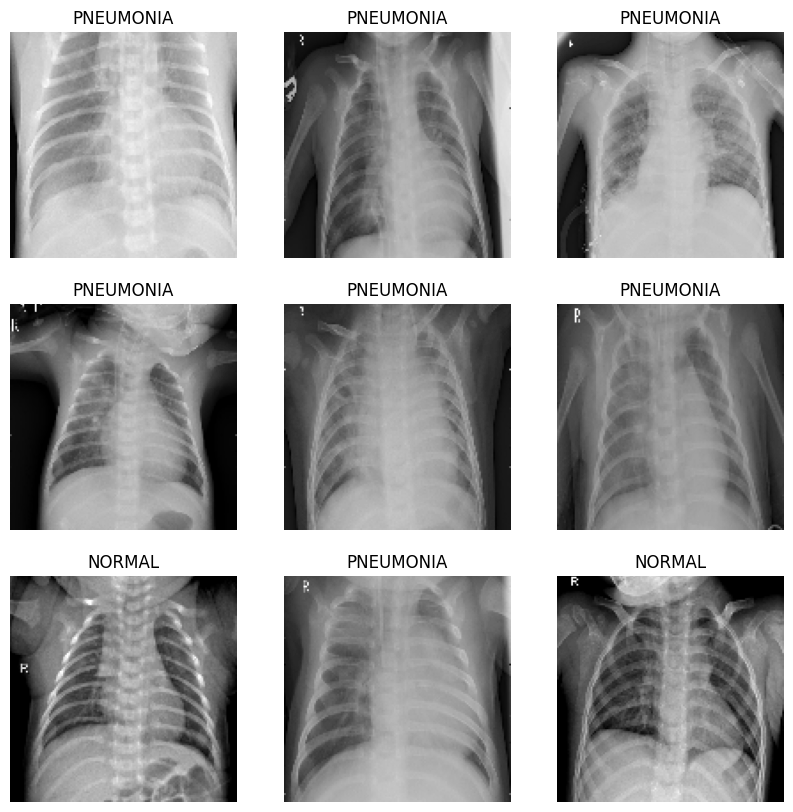

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()[:, :, 0], cmap='gray')
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.show()


##**4. Modelamiento**

Vamos a utilizar la arquitectura de una Red Neuronal Convolucional, la cual se vizualiza de la siguiente manera:

![Redes Convolucionales](https://miro.medium.com/max/700/1*L1NzxHnhto2hn1TaDRoudQ.png)

Para ello, lo primero que definiremos, será nuestro modelo.

In [84]:
model = Sequential(name="Mi_primer_RNC")

Capas de Preparación de Datos

In [85]:
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
model.add(Rescaling(1./255,name='Capa_Reescalado'))

model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Capas de Entrenamiento

Las capas ***Conv2D***, ***MaxPooling2D*** y ***AveragePooling2D*** son componentes fundamentales en las redes neuronales convolucionales (CNN) que se utilizan ampliamente en tareas de visión por computadora, como el procesamiento de imágenes.



*   La capa ***Conv2D*** realiza la opreación de convolución en una imágen de entrada, lo que implica desplizar un kernel (ventana pequeña) sobre la imágen y calcular los roductos escalares entre los valores de píxeles de la imagen y los valores del kernel. Esto nos permite detectar patrones y características en la imagen, como bordes, texturas y detalles relevantes. Este tipo de capa requiere: el número de kernels, el tamaño del kernel y la funcióñ de activación:

> `Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_1')`


*   La capa ***MaxPooling2D*** realiza la operación de agrupación (pooling) en la imagen de entrada. En particular, realiza el max-pooling, que implica dividir la imagen en regiones y tomar el valor máximo de cada región. Esto permite reducir el tamaño espacial de la imagen, lo que reduce la cantidad de parámetros en la red y ayuda a aprender características invariantes a pequeñas traslaciones o deformaciones en la imagen. Este tipo de capa requiere: el tamaño de la ventana de agrupación y el paso (stride):

> `MaxPooling2D((2, 2), name='Max_Pool_1')`

>  En Keras, el valor predeterminado del stride para la capa MaxPooling2D es igual al tamaño de la ventana de agrupación, que en este caso es (2, 2)

*   La capa ***AveragePooling2D*** realiza una operación de agrupación en donde toma el valor promedio. Nos ayuda a reducir el tamaño espacial de la imagen y puede ayudar a aprender características invariantes.Este tipo de capa requiere: el tamaño de la ventana de agrupación y el paso (stride):

> `AveragePooling2D((2, 2), name='Avg_Pool_1')`

In [86]:
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(32, (5, 5), activation='relu', name='Capa_Convolucional_3'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 Capa_Convolucional_1 (Conv  (None, 126, 126, 128)     3584      
 2D)                                                             
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 63, 63, 128)       0         
                                                                 
 Capa_Convolucional_2 (Conv  (None, 61, 61, 64)        73792     
 2D)                                                             
                                                                 
 Avg_Pool_1 (AveragePooling  (None, 30, 30, 64)        0         
 2D)                                                 

Capas de Entrenamiento (Perceptron Multicapa)

In [87]:
model.add(Flatten(name='Flatten_Layer'))
model.add(Dropout(0.2,name='Dropout'))
model.add(Dense(100,activation='relu',name='Capa_Densa_1'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 Capa_Convolucional_1 (Conv  (None, 126, 126, 128)     3584      
 2D)                                                             
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 63, 63, 128)       0         
                                                                 
 Capa_Convolucional_2 (Conv  (None, 61, 61, 64)        73792     
 2D)                                                             
                                                                 
 Avg_Pool_1 (AveragePooling  (None, 30, 30, 64)        0         
 2D)                                                 

Capa de Salida

In [88]:
model.add(Dense(1,activation='sigmoid',name='Capa_Respuesta'))
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 Capa_Convolucional_1 (Conv  (None, 126, 126, 128)     3584      
 2D)                                                             
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 63, 63, 128)       0         
                                                                 
 Capa_Convolucional_2 (Conv  (None, 61, 61, 64)        73792     
 2D)                                                             
                                                                 
 Avg_Pool_1 (AveragePooling  (None, 30, 30, 64)        0         
 2D)                                                 

En nuestro laboratorio nuestro primer clasificador era de:

*Total params: 70,363,238*

*Trainable params: 13,102*

*Non-trainable params: 70,350,136*

Ya con nuestra arquitectura construida, compilamos nuestro modelo definiendo que función de pérdida, optimizador y métrica vamos a utilizar para construir nuestro modelo.

In [89]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['BinaryAccuracy'])


Una manera más amigable de verlo...

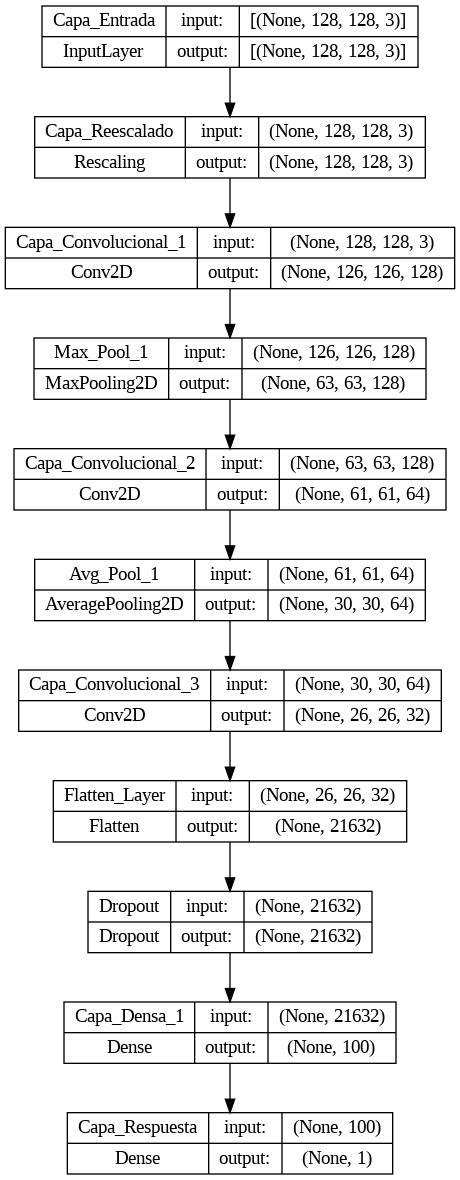

In [90]:
plot_model(model, show_shapes=True, show_layer_names=True)

Agregamos un Callback de Parada Temprana.

In [91]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [92]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
131/131 [==============================] - 35s 251ms/step - loss: 0.5398 - binary_accuracy: 0.7462 - val_loss: 0.7500 - val_binary_accuracy: 0.4458
Epoch 2/50
131/131 [==============================] - 40s 286ms/step - loss: 0.3739 - binary_accuracy: 0.8344 - val_loss: 0.2516 - val_binary_accuracy: 0.9080
Epoch 3/50
131/131 [==============================] - 33s 244ms/step - loss: 0.2375 - binary_accuracy: 0.9044 - val_loss: 0.3993 - val_binary_accuracy: 0.8188
Epoch 4/50
131/131 [==============================] - 36s 262ms/step - loss: 0.1792 - binary_accuracy: 0.9310 - val_loss: 0.2829 - val_binary_accuracy: 0.8859
Epoch 5/50
131/131 [==============================] - 36s 264ms/step - loss: 0.1637 - binary_accuracy: 0.9389 - val_loss: 0.1493 - val_binary_accuracy: 0.9444
Epoch 6/50
131/131 [==============================] - 34s 249ms/step - loss: 0.1435 - binary_accuracy: 0.9475 - val_loss: 0.1152 - val_binary_accuracy: 0.9569
Epoch 7/50
131/131 [==========================

### 4.1.1 Predicción

Al igual que con nuestros modelos anteriores, podemos realizar predicciones en nuestro conjunto de datos. Sin embargo, en este caso, debemos realizar una pequeña corrección en el proceso. Para obtener las etiquetas verdaderas y las etiquetas predichas, hemos recorrido el conjunto de datos de entrenamiento. En cada iteración, hemos utilizado el modelo para predecir las clases y luego hemos aplicado un umbral de 0.5 para asignar etiquetas binarias (1 si la probabilidad es mayor a 0.5 y 0 en caso contrario). Posteriormente, hemos convertido las listas resultantes en arreglos numpy para su posterior análisis y evaluación.`

In [93]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 78ms/step


Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [94]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.85      0.97      0.91      1108
   PNEUMONIA       0.99      0.94      0.96      3065

    accuracy                           0.95      4173
   macro avg       0.92      0.95      0.93      4173
weighted avg       0.95      0.95      0.95      4173



1/1 [==============================] - 1s 1s/step


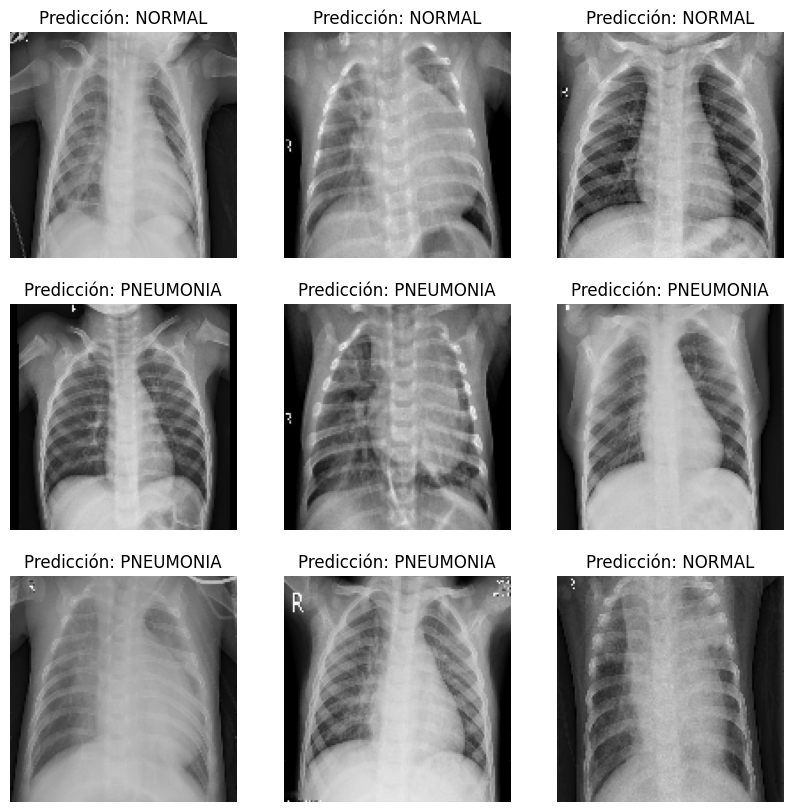

In [95]:
warnings.filterwarnings("ignore", category=UserWarning)

df = test_ds.take(1)
# Hacer predicciones en el lote de datos
pred = model.predict(df)
# Crear una figura para mostrar las imágenes y las predicciones
plt.figure(figsize=(10, 10))
# Iterar a través de las imágenes y las etiquetas verdaderas
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Normalizar la imagen si es de tipo entero
        normalized_image = images[i].numpy().astype('float32') / 255.0

        # Mostrar la imagen normalizada en color completa
        plt.imshow(normalized_image)

        # Calcular la clase predicha (0 o 1) en lugar de usar argmax
        predicted_class = 1 if pred[i] > 0.5 else 0

        plt.title(f'Predicción: {class_names[predicted_class]}')
        plt.axis("off")

plt.show()


Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

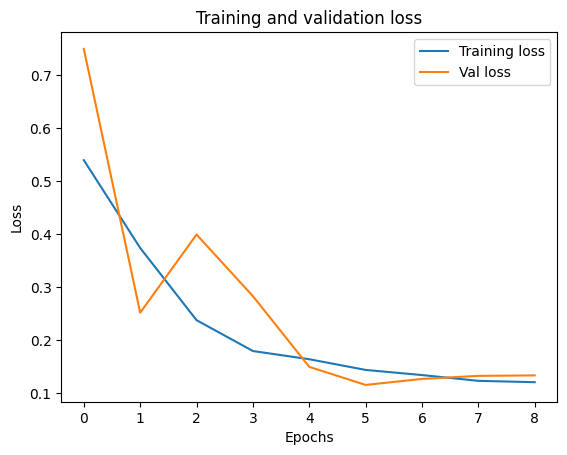

In [96]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


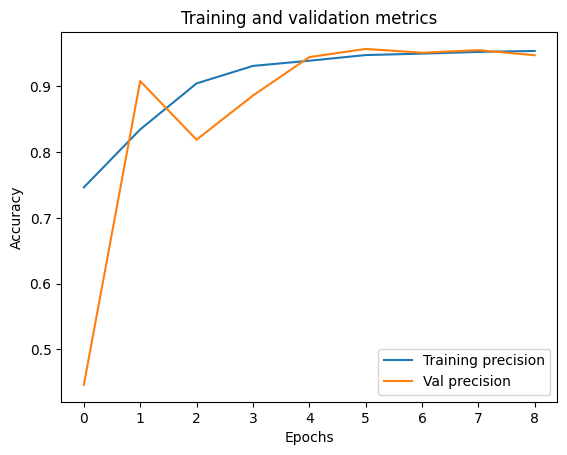

In [98]:
#plt.plot(history.history['recall_6'], label='Training recall')
#plt.plot(history.history['val_recall_6'], label='Val recall')
plt.plot(history.history['binary_accuracy'], label='Training precision')
plt.plot(history.history['val_binary_accuracy'], label='Val precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.1.2 Validación

Y podemos realizar los mismos pasos, pero esta vez con nuestros datos de validación.

In [99]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 23ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.83      0.96      0.89       233
   PNEUMONIA       0.99      0.94      0.97       810

    accuracy                           0.95      1043
   macro avg       0.91      0.95      0.93      1043
weighted avg       0.95      0.95      0.95      1043



Los resultados con los datos de validación no difieren mucho de los resultados con los datos de entrenamiento.

1/1 [==============================] - 1s 1s/step


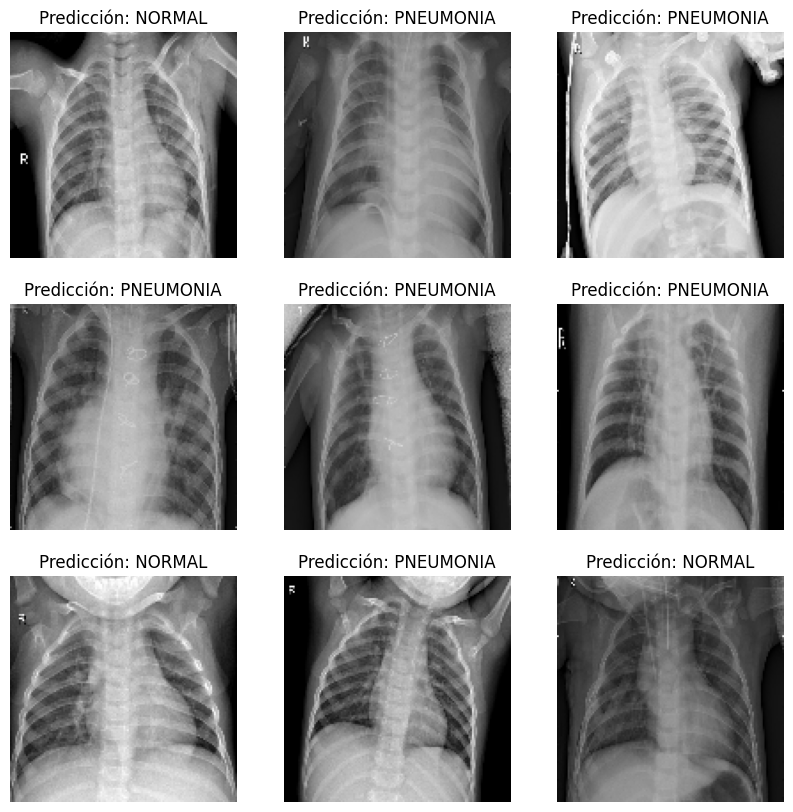

In [101]:
df = val_ds.take(1)
# Hacer predicciones en el lote de datos
pred = model.predict(df)
# Crear una figura para mostrar las imágenes y las predicciones
plt.figure(figsize=(10, 10))
# Iterar a través de las imágenes y las etiquetas verdaderas
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Normalizar la imagen si es de tipo entero
        normalized_image = images[i].numpy().astype('float32') / 255.0

        # Mostrar la imagen normalizada en color completa
        plt.imshow(normalized_image)

        # Calcular la clase predicha (0 o 1) en lugar de usar argmax
        predicted_class = 1 if pred[i] > 0.5 else 0

        plt.title(f'Predicción: {class_names[predicted_class]}')
        plt.axis("off")

plt.show()


Ahora realicemos la evaluacion con los datos de prueba que no conoce nuestro modelo:

In [102]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 35ms/step


In [103]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.86      0.56      0.68       234
   PNEUMONIA       0.78      0.95      0.86       390

    accuracy                           0.80       624
   macro avg       0.82      0.76      0.77       624
weighted avg       0.81      0.80      0.79       624



1/1 [==============================] - 2s 2s/step


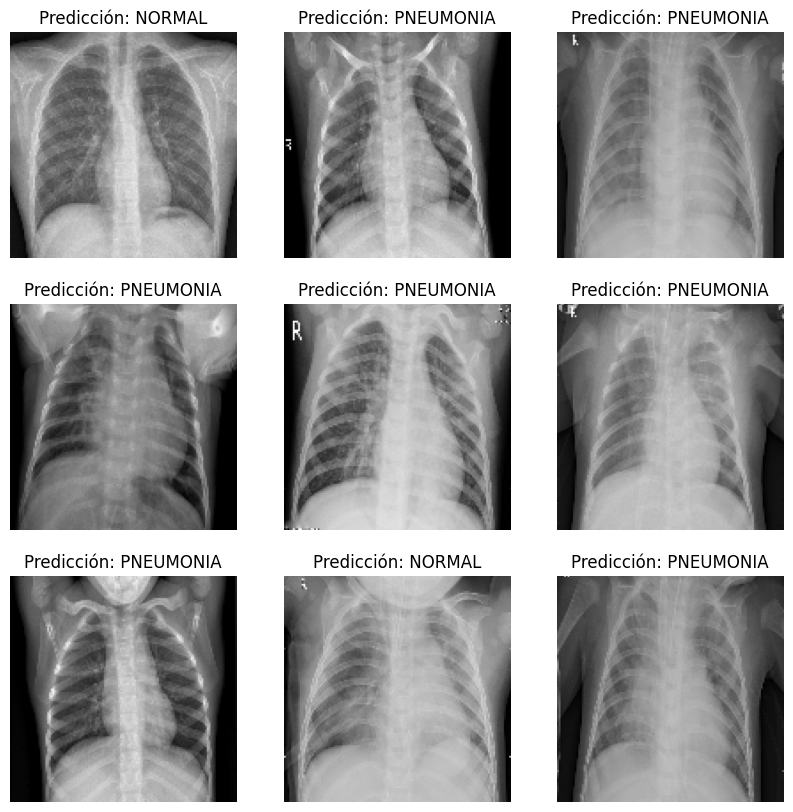

In [104]:
df = test_ds.take(1)
# Hacer predicciones en el lote de datos
pred = model.predict(df)
# Crear una figura para mostrar las imágenes y las predicciones
plt.figure(figsize=(10, 10))
# Iterar a través de las imágenes y las etiquetas verdaderas
for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Normalizar la imagen si es de tipo entero
        normalized_image = images[i].numpy().astype('float32') / 255.0

        # Mostrar la imagen normalizada en color completa
        plt.imshow(normalized_image)

        # Calcular la clase predicha (0 o 1) en lugar de usar argmax
        predicted_class = 1 if pred[i] > 0.5 else 0

        plt.title(f'Predicción: {class_names[predicted_class]}')
        plt.axis("off")

plt.show()



En resumen de las 3 evaluaciones tenemos:

| Datos | Recall | Accuracy |
|-------|--------------|--------------|
| Train | Normal 0.97, Neumonia 0.94 | 0.95|
| Val | Normal 0.96, Neumonia 0.94 | 0.95|
| Test | Normal 0.56, Neumonia 0.95 | 0.80|

Con los modelos desconocidos, la clase normal baja mucho el recall y se ve amplia diferencia entre el accuracy del modelo (Sobreajuste).

### 4.2 Búsqueda de Hiperparámetros

Hay muchos hiperparámetros por entonar en el modelo, podríamos utilizar GridSearch, sin embargo, no lo recomendamos debido a la gran cantidad de hiperparámetros que hay que entrenar.

Para ello, construimos una función que nos permita construir la Red Neuronal esperada y utilizamos la función [RandomizedSearchCV](https://keras.io/guides/keras_tuner/getting_started/) integrada directamente con Keras.

In [44]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = 1
    n_layers_DCN = hp.Choice('n_layers_DCN', [1, 2])
    filtros = hp.Choice('filtros', ['[128, 64, 32, 16]','[200, 100, 50, 20]','[64, 32, 16, 8]'])
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[10, 20, 30]','[50, 30, 10]'])
    dropout = hp.Choice('dropout', [0.1, 0.3, 0.5])

    filtros = eval(filtros)
    neuronas_MLP = eval(neuronas_MLP)

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
    clf.add(Rescaling(1./255,name='Rescaling_Layer'))

    for i in range(n_layers_MLP):
        clf.add(Conv2D(filtros[i], (3, 3), activation='relu', name='Capa_Convolucional_{0}'.format(i)))
        clf.add(MaxPooling2D((2, 2), name='Max_Pool_{0}'.format(i)))

    clf.add(Conv2D(32, (5, 5), activation='relu', name='Capa_Convolucional_3'))
    clf.add(Flatten(name='Flatten_Layer'))
    for i in range(n_layers_MLP):
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))
        clf.add(Dense(neuronas_MLP[i], activation='linear', name = 'Capa_Oculta_MLP_{0}'.format(i)))

    clf.add(Dense(output, activation='sigmoid', name= 'Capa_Respuesta'))

    clf.compile(loss='binary_crossentropy',
                optimizer='sgd',
                #metrics=["accuracy", tf.keras.metrics.Recall()])
                metrics=['BinaryAccuracy'])
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_binary_accuracy",
    project_name="pneumonia_detection",
    seed=123,
    max_trials=10)

Ya con nuestros valores de búsqueda definidos dentro de nuestra función, y nuestro objeto tuner inicializado. Podemor realizar la búsqueda de los hierparámetros como ya hemos venido realizandolo.

**Nota**: Para este paso, utilizamos el GPU de la máquina de Google Colab, con el fin de realizar el proceso de entrenamiento mucho más rapido.

Este fragmento de código, nos permite evaluar si tenemos disponible una GPU dentro del ambiente de Google Colab.

In [45]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [46]:
with tf.device('/device:GPU:0'):
  tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=30)

best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 13m 34s]
val_binary_accuracy: 0.972195565700531

Best val_binary_accuracy So Far: 0.9769894480705261
Total elapsed time: 01h 37m 44s


Podemos ver los hiperparámetros y desempeño de los 10 modelos que se revisaron en la búsqueda de hiperparámetros.

In [47]:
tuner.results_summary()

Results summary
Results in ./pneumonia_detection
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
n_layers_DCN: 1
filtros: [128, 64, 32, 16]
n_layers_MLP: 3
neuronas_MLP: [50, 30, 10]
dropout: 0.5
Score: 0.9769894480705261

Trial 04 summary
Hyperparameters:
n_layers_DCN: 2
filtros: [200, 100, 50, 20]
n_layers_MLP: 3
neuronas_MLP: [10, 20, 30]
dropout: 0.3
Score: 0.9741131067276001

Trial 06 summary
Hyperparameters:
n_layers_DCN: 2
filtros: [128, 64, 32, 16]
n_layers_MLP: 2
neuronas_MLP: [10, 20, 30]
dropout: 0.3
Score: 0.9731543660163879

Trial 08 summary
Hyperparameters:
n_layers_DCN: 2
filtros: [128, 64, 32, 16]
n_layers_MLP: 1
neuronas_MLP: [10, 20, 30]
dropout: 0.1
Score: 0.9731543660163879

Trial 03 summary
Hyperparameters:
n_layers_DCN: 1
filtros: [128, 64, 32, 16]
n_layers_MLP: 3
neuronas_MLP: [50, 30, 10]
dropout: 0.3
Score: 0.972195565700531

Trial 09 summary
Hyperparameters:
n_layers_DCN: 2
filtros: [128, 64, 32,

Y realizamos la descarga de nuestro modelo, junto con la vizualización de la arquitectura escogida por la búsqueda Aleatoria.

In [48]:
best_model.save('best_model_pneumonia.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 Capa_Convolucional_0 (Conv  (None, 126, 126, 128)     3584      
 2D)                                                             
                                                                 
 Max_Pool_0 (MaxPooling2D)   (None, 63, 63, 128)       0         
                                                                 
 Capa_Convolucional_1 (Conv  (None, 61, 61, 64)        73792     
 2D)                                                             
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 30, 30, 64)        0         
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Realizamos los mismos pasos que hicimos con nuestro modelo base, para poder comparar

In [49]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 104ms/step


In [50]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95      1108
   PNEUMONIA       0.98      0.98      0.98      3065

    accuracy                           0.98      4173
   macro avg       0.97      0.97      0.97      4173
weighted avg       0.98      0.98      0.98      4173



In [51]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 22ms/step


In [52]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.94      0.95      0.95       233
   PNEUMONIA       0.99      0.98      0.99       810

    accuracy                           0.98      1043
   macro avg       0.97      0.97      0.97      1043
weighted avg       0.98      0.98      0.98      1043



In [53]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 98ms/step


In [54]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

      NORMAL       0.95      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



En resumen de las 3 evaluaciones tenemos:

| Datos | Recall | Accuracy |
|-------|--------------|--------------|
| Train | Normal 0.95, Neumonia 0.98| 0.98|
| Val | Normal 0.95, Neumonia 0.98 | 0.98|
| Test | Normal 0.41, Neumonia 0.99 | 0.77|

Con los modelos desconocidos, la clase normal baja mucho el recall y se ve amplia diferencia entre el accuracy del modelo (Sobreajuste).

## 6. Hands on

1.   Modifique el modelo inicial cambiando otros valores de padding y strike en las capas Conv2D. Ten en cuenta los valores por defecto que usa [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) son: strides=(1, 1), padding='valid'.


> `model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu'))`


2.   Utilice el conjunto de datos de https://www.kaggle.com/datasets/alxmamaev/flowers-recognition y genere una red convolucional que le permita clasificar las imágenes de las flores.

3.   ¿Cómo podemos utilizar una red preentrenada?